In [1]:
import json
from string import ascii_letters

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.manifold import TSNE
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

sns.set_theme()

### Анализ данных

In [2]:
df = pd.read_csv('./data/ЕНСТРУ.csv').reset_index(drop=True)

In [3]:
df.head()

,Наименование,Код,Характеристика,Наименование с характеристикой,Отдел,Группа,Класс,Вид,Подвид,Ведомственный классификатор
0,Уротропин технический,201442.900.000008,"(гексаметилентетрамин, гексамин), марка М","Уротропин технический (гексаметилентетрамин, г...",20,201.0,2014.0,20144.0,201442,201442.900
1,Уротропин технический,201442.900.000011,"(гексаметилентетрамин), марка К","Уротропин технический (гексаметилентетрамин), ...",20,201.0,2014.0,20144.0,201442,201442.900
2,Кислота кремнефтористоводородная,201324.600.000001,"(гексафторокремниевая кислота, гексафторосилик...",Кислота кремнефтористоводородная (гексафторокр...,20,201.0,2013.0,20132.0,201324,201324.600
3,Кристаллический фиолетовый,201221.900.000000,"(N,N,N,N,N,N-Гексаметилпарарозанилин; кристалл...","Кристаллический фиолетовый (N,N,N,N,N,N-Гексам...",20,201.0,2012.0,20122.0,201221,201221.900
4,Кабель оптико-волоконный,273111.300.000020,1 волокно,Кабель оптико-волоконный 1 волокно,27,273.0,2731.0,27311.0,273111,273111.300


Наша задача - по наименованию товара предложить потенциальный его код.

In [4]:
len(df['Наименование'].unique())

9386

In [5]:
len(df['Код'].unique())

35318

In [6]:
len(df['Ведомственный классификатор'].unique())

3527

Имеем отображение: \
$f\colon X \to Y$\
где
- каждому $x \in 𝑋$ сопоставляет множество $f(x) \subseteq Y$
- Для любого $y \in Y$ существует единственный $x \in X$, такой что $y \in f(x)$.

Или проще говоря один ко многим, multilabel classification. Но имея дополнительную информацию (такую как "Характеристика", "Наименование с характеристикой") можно однозначно определить код.

Использование при обучении признаков "отдел", "группа", "класс", "вид", "подвид" приведут к даталику при обучении и буду завышать качество нашей модели. Удалим их.
Но как видно, отношение между "Наименование" и "Ведомственный классификатор" - многие к одному. То есть можно построить классификацию на промежуточном этапе.

In [7]:
df.drop(columns=["Отдел", "Группа", "Класс", "Вид", "Подвид"], inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(35318, 5)

In [9]:
df.head(10)

,Наименование,Код,Характеристика,Наименование с характеристикой,Ведомственный классификатор
0,Уротропин технический,201442.900.000008,"(гексаметилентетрамин, гексамин), марка М","Уротропин технический (гексаметилентетрамин, г...",201442.900
1,Уротропин технический,201442.900.000011,"(гексаметилентетрамин), марка К","Уротропин технический (гексаметилентетрамин), ...",201442.900
2,Кислота кремнефтористоводородная,201324.600.000001,"(гексафторокремниевая кислота, гексафторосилик...",Кислота кремнефтористоводородная (гексафторокр...,201324.600
3,Кристаллический фиолетовый,201221.900.000000,"(N,N,N,N,N,N-Гексаметилпарарозанилин; кристалл...","Кристаллический фиолетовый (N,N,N,N,N,N-Гексам...",201221.900
4,Кабель оптико-волоконный,273111.300.000020,1 волокно,Кабель оптико-волоконный 1 волокно,273111.300
5,Холодильник,281332.000.000070,1 и 2 ступени компрессора,Холодильник 1 и 2 ступени компрессора,281332.000
6,Система контроля и управления доступом,329959.900.000056,1 класс,Система контроля и управления доступом 1 класс,329959.900
7,Проволока,259315.700.000002,"1 класс, диаметр 0,16-1 мм, оцинкованная","Проволока 1 класс, диаметр 0,16-1 мм, оцинкова...",259315.700
8,Проволока,259315.700.000003,"1 класс, диаметр 1,05-2,5 мм, оцинкованная","Проволока 1 класс, диаметр 1,05-2,5 мм, оцинко...",259315.700
9,Проволока,259315.700.000004,"1 класс, диаметр 2,55-5 мм, оцинкованная","Проволока 1 класс, диаметр 2,55-5 мм, оцинкова...",259315.700


При решении задачи классификации есть недостаток: для некоторых классов существует только один семпл.
Потенциальные решения:
- удалить такие семплы - прохо
- синтетические данные (генерация) - сложно для данного домена
- метчинг на основе n-грамм или слов - просто в реализации

In [10]:
df['Ведомственный классификатор'].value_counts()

Ведомственный классификатор
302040.300    1243
242013.900     811
293230.990     587
212013.990     500
222129.700     392
              ... 
265228.900       1
244530.570       1
259911.271       1
259911.251       1
259911.312       1
Name: count, Length: 3527, dtype: int64

### Визуализация данных (после дообучения)

In [2]:
df = pd.read_csv('./data/val.csv')
df = df.sample(frac=1, random_state=42).head(2500)  # shuffle + take first 1000

In [5]:
texts = df['text'].tolist()
labels = df['label'].tolist()

with open('./data/id2label.json', 'r', encoding='utf-8') as f:
    id2label = json.load(f)
    id2label = {int(key): value for key, value in id2label.items()}

num_labels = len(id2label.keys())

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "intfloat/multilingual-e5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained('./results/checkpoint-30500', num_labels=num_labels).to(device)
model.eval();

In [7]:
emb_dim = 768

batch_dict = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    last_hidden_state = model(**batch_dict, output_hidden_states=True).hidden_states[-1]
    embeddings = last_hidden_state[:, 0, :].contiguous().detach().cpu().numpy()

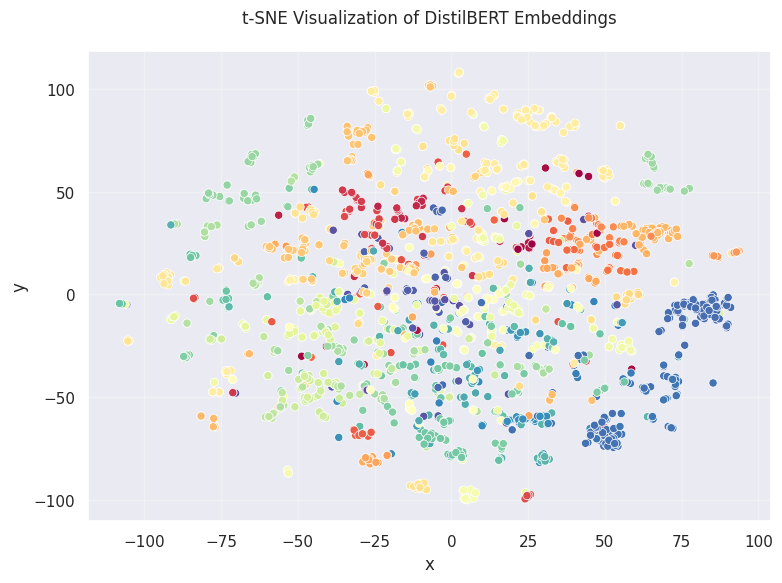

In [9]:
# === Преобразование с помощью t-SNE ===
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# === Построение датафрейма для seaborn ===
df = pd.DataFrame({
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
    "label": labels
})

palette = sns.color_palette("Spectral", as_cmap=True)
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="label",
    palette=palette,
    s=35,                 
    linewidth=0.5   
)

plt.title("t-SNE Visualization of DistilBERT Embeddings", pad=20)  # Добавлен отступ
plt.tight_layout()
plt.legend().remove()  # Более корректный способ удаления легенды
plt.grid(True, alpha=0.3)  # Добавлена легкая сетка для ориентира
plt.show()

/home/schetinnikov.k/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


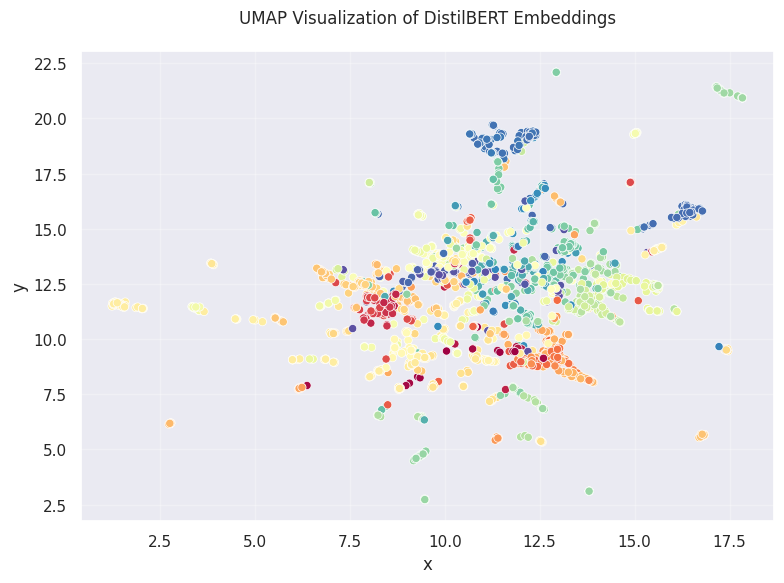

In [10]:
reducer = umap.UMAP(
    n_components=2,          # 2D визуализация
    random_state=42
)
embeddings_2d = reducer.fit_transform(embeddings)

# === Построение датафрейма для seaborn ===
df = pd.DataFrame({
    "x": embeddings_2d[:, 0],
    "y": embeddings_2d[:, 1],
    "label": labels
})

palette = sns.color_palette("Spectral", as_cmap=True)
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="label",
    palette=palette,
    s=35,                 
    linewidth=0.5   
)

plt.title("UMAP Visualization of DistilBERT Embeddings", pad=20)  # Добавлен отступ
plt.tight_layout()
plt.legend().remove()  # Более корректный способ удаления легенды
plt.grid(True, alpha=0.3)  # Добавлена легкая сетка для ориентира
plt.show()